In [1]:
import pathlib
import pickle
from typing import Optional, Sequence, Tuple, Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import hier
import main
import metrics

In [2]:
experiment_root = pathlib.Path(
    '/home/jack/projects/2022-01-hierarchical/experiments/2022-02-28-tiny-incomplete-lr0.1-b256/')

with open('resources/hierarchy/tiny_imagenet_fiveai.csv') as f:
    tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))

experiment_dirs = {
    'flat': experiment_root / 'complete-flat',
    'hier': experiment_root / 'complete-hier',
    'hxe-0.1': experiment_root / 'complete-hxe-0.1',
    'hxe-0.2': experiment_root / 'complete-hxe-0.2',
    'hxe-0.5': experiment_root / 'complete-hxe-0.5',
    'multilabel': experiment_root / 'complete-multilabel-sum',
}

# with open('resources/hierarchy/tiny_imagenet_fiveai.csv') as f:
#     tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))
# with open('resources/hierarchy/tiny_imagenet_fiveai_incomplete_subset.txt') as f:
#     name_subset = list(map(str.strip, f.readlines()))

# name_to_node = {name: i for i, name in enumerate(names)}
# node_subset = [name_to_node[name] for name in name_subset]
# tree, _, _ = hier.subtree(tree, node_subset)

# experiment_dirs = {
#     'flat': experiment_root / 'incomplete-flat',
#     'hier': experiment_root / 'incomplete-hier',
# }

In [3]:
def load_results(experiment_dir, epoch):
    epoch_str = '{:04d}'.format(epoch)
    outputs_file = experiment_dir / f'predictions/output-epoch-{epoch_str}.pkl'
    # operating_points_file = experiment_dir / f'predictions/operating-points-epoch-{epoch_str}.pkl'
    full_outputs_file = experiment_dir / f'predictions/full-output-epoch-{epoch_str}.pkl'

    with open(outputs_file, 'rb') as f:
        outputs = pickle.load(f)
    with open(full_outputs_file, 'rb') as f:
        full_outputs = pickle.load(f)

    outputs.update(full_outputs)
    return outputs

In [4]:
outputs = load_results(experiment_dirs['multilabel'], 100)

In [5]:
# Re-normalize.
# outputs['prob'] = outputs['prob'] / outputs['prob'][:, [0]]

In [6]:
specificity = -tree.num_leaf_descendants()

In [7]:
# Minimize number of leaf descendants then maximize depth.
node_mask = (tree.num_children() != 1)
pred_seqs = [main.prediction_sequence(specificity, p, condition=node_mask) for p in outputs['prob']]
prob_seqs = [outputs['prob'][i, pred_i] for i, pred_i in enumerate(pred_seqs)]

In [8]:
is_leaf = tree.leaf_mask()
most_specific_pred = np.array([pr[-1] for pr in pred_seqs])
np.all(is_leaf[most_specific_pred])

True

In [9]:
# Truncate at LCA.
find_lca_fn = hier.FindLCA(tree)
lca_seqs = [find_lca_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
pred_seqs = [hier.truncate_given_lca(gt, pr, lca)
             for gt, pr, lca in zip(outputs['gt'], pred_seqs, lca_seqs)]
# TODO: Remove redundant elements from pred_seqs and scores?
len([pr for pr in pred_seqs if len(set(pr)) != len(pr)]) / len(pred_seqs)

0.0

In [10]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)
# depth_metric = metrics.LCAMetric(tree, tree.depths() + 1)
metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_deficient': info_metric.deficient,
    'info_excess': info_metric.excess,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'info_f1': info_metric.f1,
    'info_dist': info_metric.dist,
    'info_lca': info_metric.value_at_lca,
    'info_gt': info_metric.value_at_gt,
    'info_pr': info_metric.value_at_pr,
    'depth_deficient': depth_metric.deficient,
    'depth_excess': depth_metric.excess,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
    'depth_f1': depth_metric.f1,
    'depth_dist': depth_metric.dist,
    'depth_lca': depth_metric.value_at_lca,
    'depth_gt': depth_metric.value_at_gt,
    'depth_pr': depth_metric.value_at_pr,
}

In [11]:
metric_seqs = {}
for field in metric_fns:
    metric_fn = metric_fns[field]
    # TODO: Could vectorize if necessary.
    metric_seqs[field] = [metric_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]

In [12]:
totals, thresholds = main.pool_operating_points(prob_seqs, metric_seqs)

In [13]:
_, first_index = np.unique(-thresholds, return_index=True)
last_index = np.concatenate([first_index[1:], [len(thresholds)]]) - 1
thresholds = thresholds[last_index]
totals = {k: v[np.concatenate([[0], last_index])] for k, v in totals.items()}

In [14]:
means = {k: v / len(outputs['gt']) for k, v in totals.items()}

In [15]:
# Evaluate predictions using majority rule.
# Maximize specificity, then maximize confidence.
pred_maj = main.lexargmin_where(
    np.broadcast_arrays(-outputs['prob'], -specificity),
    (outputs['prob'] > 0.5) & node_mask)
metrics_maj = {field: np.mean(metric_fn(outputs['gt'], pred_maj)) for field, metric_fn in metric_fns.items()}

In [16]:
# means['info_recall'] = means['info_lca'] / means['info_gt']
# means['info_precision'] = means['info_lca'] / means['info_pr']

# # Add 1 to depth to count root node.
# means['depth_recall'] = means['depth_lca'] / means['depth_gt']
# means['depth_precision'] = means['depth_lca'] / means['depth_pr']

# means['depth_recall'] = (means['depth_lca'] + 1) / (means['depth_gt'] + 1)
# means['depth_precision'] = (means['depth_lca'] + 1) / (means['depth_pr'] + 1)

In [17]:
def plot_metrics(x, y):
    plt.plot(means[x], means[y])
    plt.plot(metrics_maj[x], metrics_maj[y], marker='o')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.show()

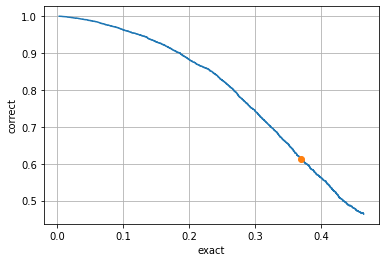

In [18]:
plot_metrics('exact', 'correct')

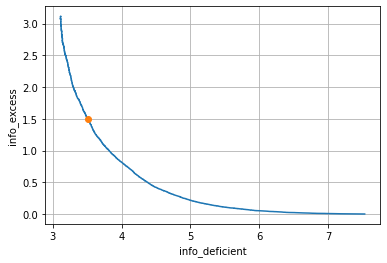

In [19]:
plot_metrics('info_deficient', 'info_excess')

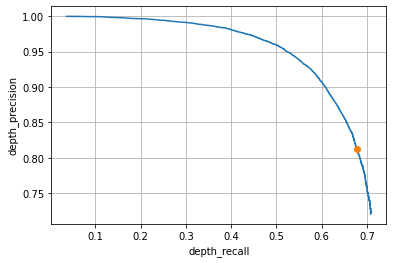

In [20]:
plot_metrics('depth_recall', 'depth_precision')

In [21]:
def add_metrics(means):
    means = dict(means)
#     means['info_recall'] = means['info_lca'] / means['info_gt']
#     means['info_precision'] = means['info_lca'] / means['info_pr']
#     means['depth_recall'] = means['depth_lca'] / means['depth_gt']
#     means['depth_precision'] = means['depth_lca'] / means['depth_pr']
    return means

In [22]:
risk_matrix = {
    name: metric_fn(
        np.arange(tree.num_nodes())[:, None],
        tree.leaf_subset()[None, :])
    for name, metric_fn in metric_fns.items()}

In [23]:
def argmax_expected_reward(p, reward):
    return np.argmax(np.dot(p, reward.T), axis=-1)

In [24]:
def predict_and_evaluate(outputs):
    pred = {}
    pred['leaf'] = main.argmax_where(outputs['prob'], tree.leaf_mask(), axis=-1)
    pred['majority'] = main.lexargmin_where(
        np.broadcast_arrays(-outputs['prob'], -specificity),
        (outputs['prob'] > 0.5) & node_mask,
        axis=-1)

    pred['crm_info_f1'] = np.argmax(
        np.dot(outputs['prob'][:, tree.leaf_mask()], risk_matrix['info_f1'].T),
        axis=-1)
    pred['crm_info_dist'] = np.argmin(
        np.dot(outputs['prob'][:, tree.leaf_mask()], risk_matrix['info_dist'].T),
        axis=-1)
    pred['crm_depth_f1'] = np.argmax(
        np.dot(outputs['prob'][:, tree.leaf_mask()], risk_matrix['depth_f1'].T),
        axis=-1)
    pred['crm_depth_dist'] = np.argmin(
        np.dot(outputs['prob'][:, tree.leaf_mask()], risk_matrix['depth_dist'].T),
        axis=-1)

    # Truncate at LCA.
    pred = {
        method: hier.truncate_given_lca(
            outputs['gt'], pred[method],
            hier.lca(tree, outputs['gt'], pred[method]))
        for method in pred
    }
    means = {
        method: add_metrics({
            field: np.mean(fn(outputs['gt'], pred[method]))
            for field, fn in metric_fns.items()
        })
        for method in pred
    }
    return means

In [25]:
predict_and_evaluate(outputs)

{'leaf': {'exact': 0.4641,
  'correct': 0.4641,
  'info_deficient': 3.113370736843408,
  'info_excess': 3.113370736843408,
  'info_recall': 0.5926963224389019,
  'info_precision': 0.5926963224389019,
  'info_f1': 0.5926963224389019,
  'info_dist': 6.226741473686816,
  'info_lca': 4.530485452931316,
  'info_gt': 7.643856189774724,
  'info_pr': 7.643856189774724,
  'depth_deficient': 2.3089,
  'depth_excess': 2.1067,
  'depth_recall': 0.7085064302364301,
  'depth_precision': 0.7207632772782772,
  'depth_f1': 0.7101208303170184,
  'depth_dist': 4.4156,
  'depth_lca': 5.6911,
  'depth_gt': 8.0,
  'depth_pr': 7.7978},
 'majority': {'exact': 0.3688,
  'correct': 0.6135,
  'info_deficient': 3.506934406529687,
  'info_excess': 1.5027388657817953,
  'info_recall': 0.5412087407896352,
  'info_precision': 0.7166357095034075,
  'info_f1': 0.5788248872274466,
  'info_dist': 5.009673272311482,
  'info_lca': 4.136921783245037,
  'info_gt': 7.643856189774724,
  'info_pr': 5.639660649026832,
  'depth_d

In [26]:
def construct_curves(outputs, min_threshold=None):
    pred_seqs = [main.prediction_sequence(specificity, p, threshold=min_threshold, condition=node_mask) for p in outputs['prob']]
    prob_seqs = [outputs['prob'][i, pred_i] for i, pred_i in enumerate(pred_seqs)]

    # Truncate at LCA.
    find_lca_fn = hier.FindLCA(tree)
    lca_seqs = [find_lca_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
    pred_seqs = [hier.truncate_given_lca(gt, pr, lca)
                 for gt, pr, lca in zip(outputs['gt'], pred_seqs, lca_seqs)]
    
    metric_seqs = {
        field: [fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
        for field, fn in metric_fns.items()
    }

    totals, thresholds = main.pool_operating_points(prob_seqs, metric_seqs)

    _, first_index = np.unique(-thresholds, return_index=True)
    last_index = np.concatenate([first_index[1:], [len(thresholds)]]) - 1
    thresholds = thresholds[last_index]
    totals = {k: v[np.concatenate([[0], last_index + 1])] for k, v in totals.items()}

    means = {k: v / len(outputs['gt']) for k, v in totals.items()}
    means = add_metrics(means)
    return means, thresholds

In [27]:
epoch = 100
# min_threshold = 0.5
min_threshold = 0.01
curves = {}
points = {}
for name, experiment_dir in experiment_dirs.items():
    outputs = load_results(experiment_dir, epoch)
    curves[name], _ = construct_curves(outputs, min_threshold)
    points[name] = predict_and_evaluate(outputs)
    print('frac with a leaf node > 0.5:', name,
          np.mean(np.max(outputs['prob'][:, tree.leaf_mask()], axis=-1) > 0.5))

frac with a leaf node > 0.5: flat 0.6407
frac with a leaf node > 0.5: hier 0.6783
frac with a leaf node > 0.5: hxe-0.1 0.6323
frac with a leaf node > 0.5: hxe-0.2 0.5745
frac with a leaf node > 0.5: hxe-0.5 0.2259
frac with a leaf node > 0.5: multilabel 0.529


In [28]:
MARKERS = {
    'leaf': 's',
    'majority': 'o',
}

COLORS = dict(zip(experiment_dirs,
                  map(matplotlib.cm.get_cmap('tab10'),
                      range(len(experiment_dirs)))))

In [29]:
def plot_metrics(x, y, extra=None):
    for name in curves:
        plt.plot(curves[name][x], curves[name][y], label=name,
                 color=COLORS[name])
        for method in ['majority', 'leaf']:
            plt.plot(points[name][method][x], points[name][method][y],
                     marker=MARKERS[method], color=COLORS[name], markerfacecolor='none')
        if extra is not None:
            plt.plot(points[name][extra][x], points[name][extra][y],
                     marker='*', color=COLORS[name])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.legend()
    plt.show()

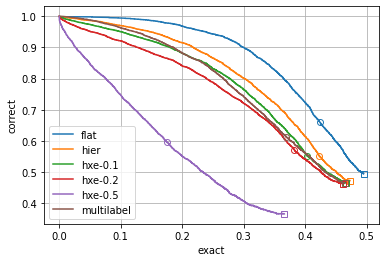

In [30]:
plot_metrics('exact', 'correct')

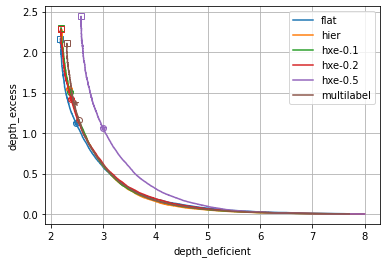

In [31]:
plot_metrics('depth_deficient', 'depth_excess', 'crm_depth_dist')

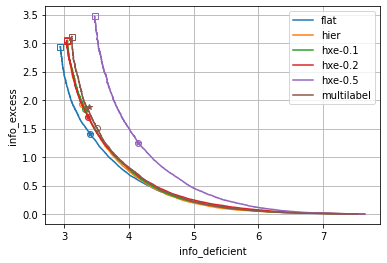

In [32]:
plot_metrics('info_deficient', 'info_excess', 'crm_info_dist')

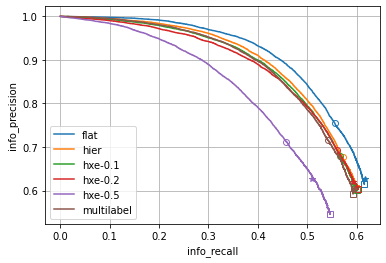

In [33]:
plot_metrics('info_recall', 'info_precision', 'crm_info_f1')

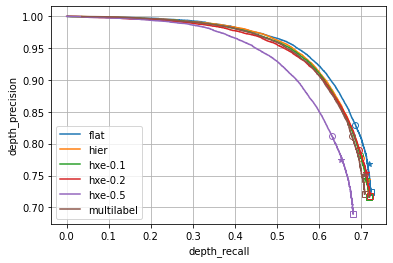

In [34]:
plot_metrics('depth_recall', 'depth_precision', 'crm_depth_f1')

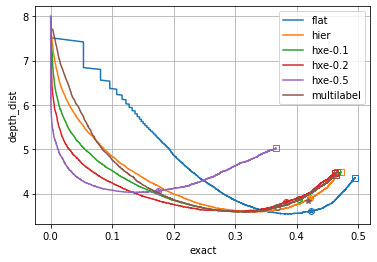

In [35]:
plot_metrics('exact', 'depth_dist', 'crm_depth_dist')

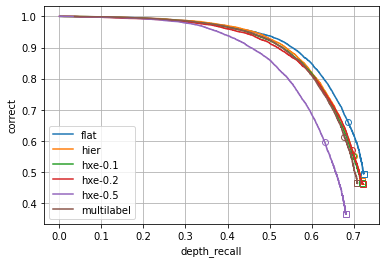

In [36]:
plot_metrics('depth_recall', 'correct')

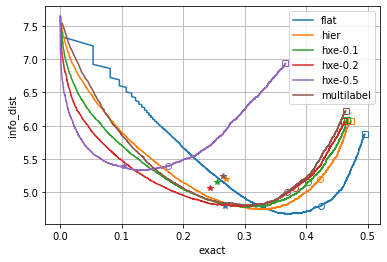

In [37]:
plot_metrics('exact', 'info_dist', 'crm_info_dist')